# QuaSaR: Identifying EEW Rings - Topology

## GOAL AND OBJECTIVES
Quake Safety Rings (synonimus with [QuSaR](https://en.wikipedia.org/wiki/Quasar)) are essentially autonomous [Rings](https://brilliant.org/wiki/ring-theory/) of sensors sharing discretized time-series of _waveform_ information to identify threats and forewarn to give man and machine a lead time to respond to harmful earthquakes.

The overall __gaol__ is to examine how the GeoNet seismic network can be augmented with a low-cost network to offer low-latency EEWs by making use of cutting-edge earthquake picking algorithms and machine learning techniques. The expected outcome is for the findings to serve as evidence for supporting a strategic deployment of a ring or rings of micro-array networks. 

The intent is to also make use of the analysis and tools is to serve as inputs for earthquake hazard risk assessment. Thereby, a community interested in operationalizing their own micro-array ring can make us of the analysis and tools to determining whether or not and how they may need to invest in building a micro-array ring.

### Objectives
1. _Understand the [topology](https://brilliant.org/wiki/topology/) (structure of connection of the units and their capabilities)_; also an axiomatic way to make sense of when two points in a set are "near" each other
   1. Retrieve data on all the operational NZ seismic stations to __map the inventory__ by types and location [git-issue #2](https://github.com/waidyanatha/quasar/issues/2).
   1. Build a __statoion fault topology space__ comprising all the operational stations within a bound of the fault line paths; such that we create a metric space _(X,d)_ comprising _X = { x,y | for all coordinate pairs of stations x and faults y}_ and a [haversine](https://math.stackexchange.com/questions/993236/calculating-a-perpendicular-distance-to-a-line-when-using-coordinates-latitude) distance function _d = x - y_; relative to the fault lines, stations, and earthquake detection role and capacity 
   1. Cluster the metric space into partially ordered __coarser topology__ of metric subspaces; essentially to make a nearest neigbour map of station fault clusters such that stations are within ___d < &epsilon;___ distance to ensure optimal EEW application performance; 
1. _Apply earthquake __picking algorithms__ on the GeoNet wave form data_
   1. Test the __standard GeoNet algorithms__ (e.g. LTS/STS, Pd, Wavefields)
   1. Test with new __machine learning and wavefield algorithms__ (e.g. , 8bit ML Picking, Wavefields)
   1. Test above picking algorithms with __simulated earthquakes__ and for __selected high risk faults__ to observe the response of the picking algorithms
   
1. _Determine ways for improving the station rings for an incremental effectiveness of EEW_
   1. Propose to __fit additional stations__ to improve the 30Km nearest neighbour cluster; then show how that improves the picking
   1. Apply the geodedic methodology to __interpolate seismic data__ for the proposed station locations 
   1. Try the earthquake __picking algorithms__ on the hypothetical network to measure effectiveness

In [ ]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'

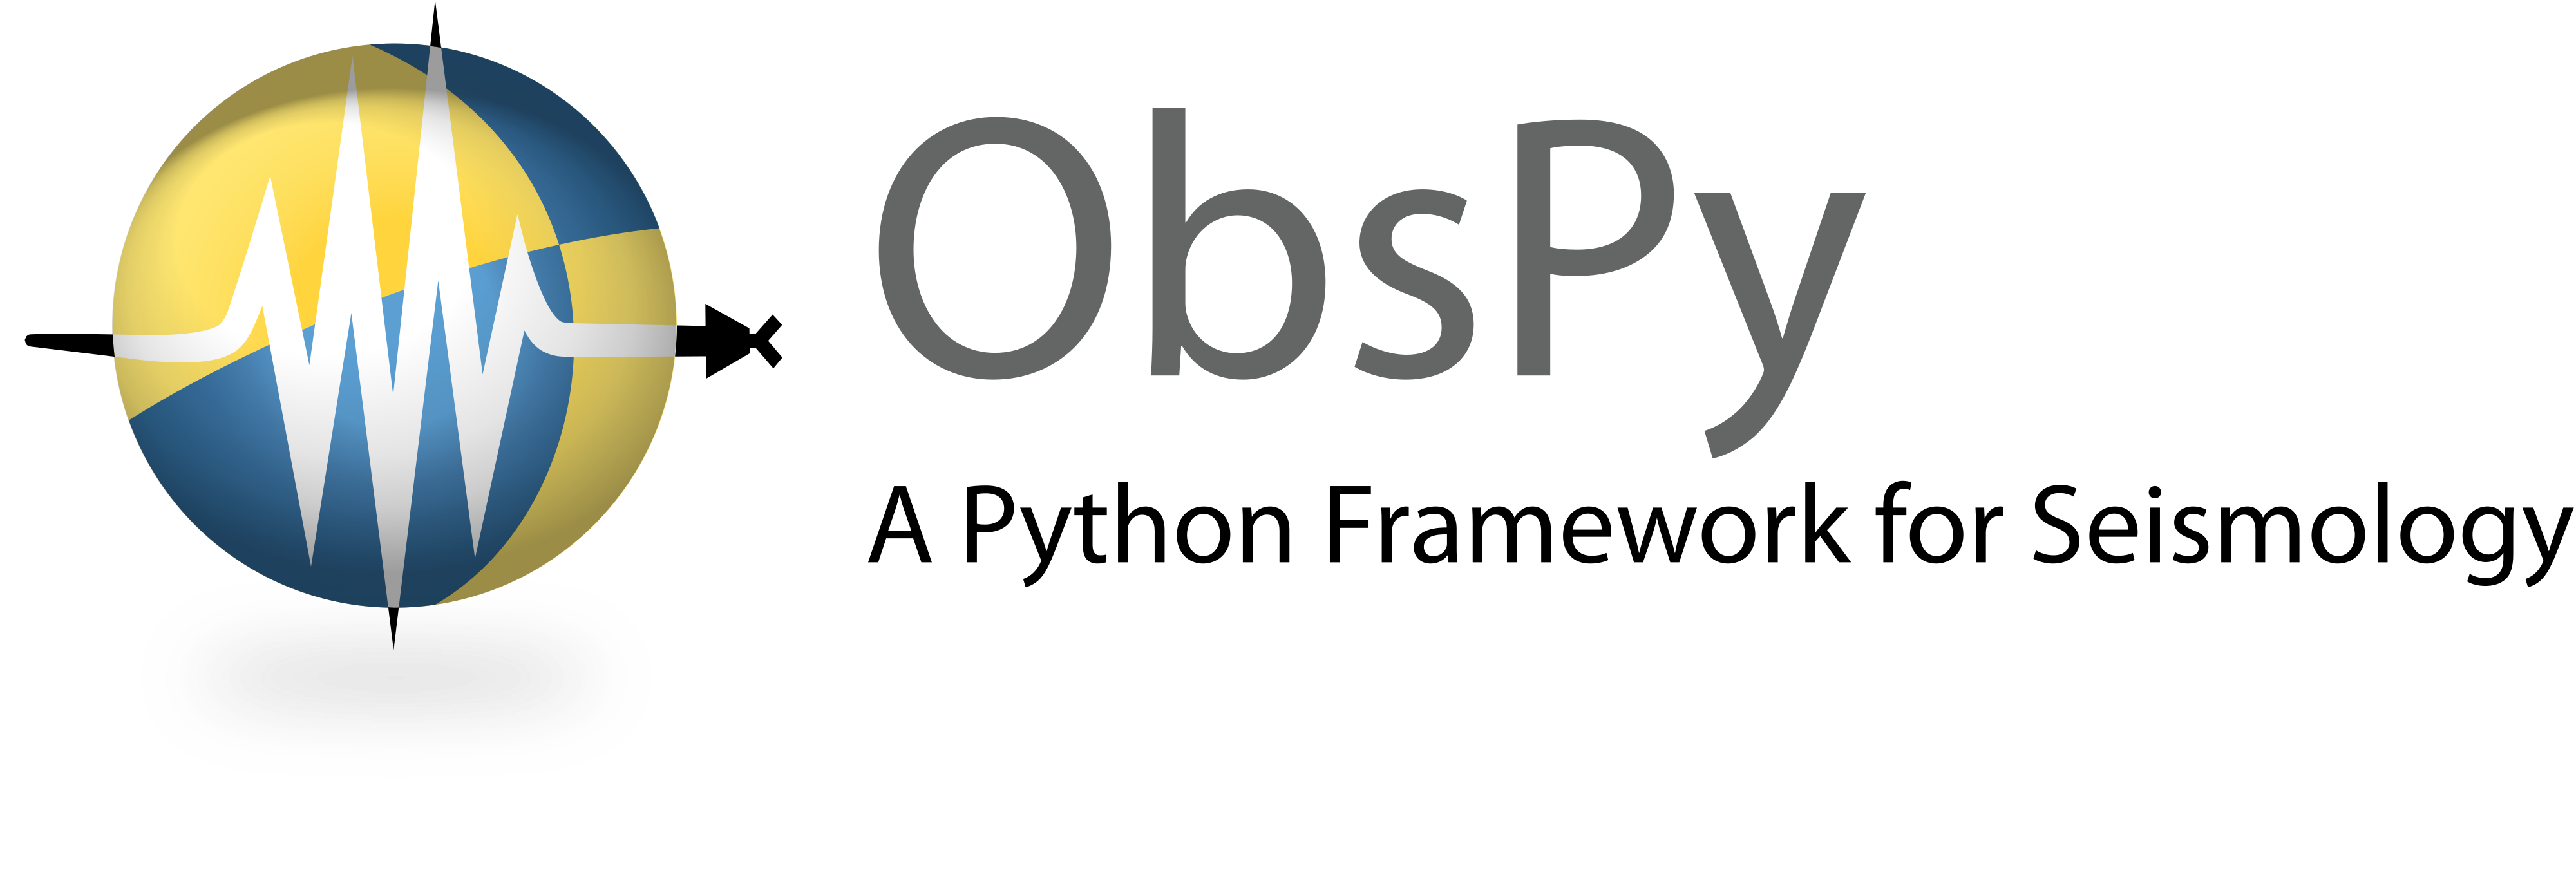

In [1]:
from IPython.display import Image
Image(filename='../images/obspy.png',width=300, height=150)

# OBJECTIVE 1.A - GET STATION AND FAULT DATA
### DEFINE data services and software modules

We make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) for sharing seismic sensor wave form data. The Obspy librarires support FDSN. The list of resources and services that are used for retrieving station inventory and waveform data.

1. FDSN station service
   1. FSDN as Client data sources; both (i) the FDSN client service and the (ii) FDSN complient GoeNet API webservice
   1. retrieve station metadata information in a FDSN StationXML format or text format for all the channels in CECS station with no time limitations: https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel&format=text
1. ObsPy
   1. wavePicker is no longer supported by ObsPy; instead the [Pyrocko](http://pyrocko.org) Snuffler for seismic data inspection and picking is recommoended

In [2]:
'''
    DICTIONARY for defining the data source (make connection) and global parameters
'''
import glob
from obspy import read_inventory
from obspy.clients.fdsn import Client
from obspy.core import read, UTCDateTime
#from datetime import date

'''
    Establish start and end time for retrieving waveform data
'''
t_start = UTCDateTime.now()-518400 #6 days ago = 60s x 60m x 24h x 6d
t_end = UTCDateTime.now()+86400 #1 day in the future = 60s x 60m x 24h
print('Retrieving active stations with a \nstart-time: {} \n & end-time: {}'.format(t_start, t_end))

st_test_data = ""     # TODO create a test set with corresponding faults
''' use either or GeoNet station service webservice URL or Obspy FDSN Client protocol to retrieve station data 
'''
#st_ws = 'https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel'
st_ws = 'https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&level=station&endafter=2020-12-31&format=xml'
s_fdsn_url_code = "GEONET"     # FDSN client URL code
''' NZ faults 
'''
s_flt_full_data = "../data/NZAFD/JSON/NZAFD_Oct_2020_WGS84.json"  # Downloaded and unzipped data
s_flt_test_data = "../data/NZAFD/JSON/NZAFD_WGS84-test.json"     # Sample of 6-10 fault attribs & features
s_flt_new_data = "https://data.gns.cri.nz/af/"                # Active Faults GeoNet database

try:
    # Set FDSN client URL to GEONET short code
    client  = Client(s_fdsn_url_code)
    print(client)
except Exception as err:
    print("Error message:", err)


Retrieving active stations with a 
start-time: 2021-01-04T03:46:04.110142Z 
 & end-time: 2021-01-11T03:46:04.110348Z
FDSN Webservice Client (base url: http://service.geonet.org.nz)
Available Services: 'dataselect' (v1.1), 'event' (v1.1), 'station' (v1.1), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


### Define station types and channels

To learn about sensor type and channel code definitions [see section in ipynb](./stations_faultlnes_plot_1a.ipynb#sensor_code_desc)

#### Class of station data processing methods
The class is defined to manage all functions for retrieving, parsing, and preparing station data in an easily useable form.
* Class _station_data()_
   * _get_channels()_ returns abbreviated channel codes
   * _get_types()_ returns a list of all seismic station types with abbreviation and description
   * _get_stations()_ returns list of all stations with code, type abbr, lat/lon pair


In [3]:
'''
    DICTIONARY for defining station, channel, fault types and coding and data filter functions
'''

''' All weak & strong motion, low gain, and mass possion sensor types '''
class station_data():
    def _init_(self, name):

        name = "station_metadata"
        return name
        
    def get_channels(self):
        channels = "UH*,VH*,LH*,BH*,SH*,HH*,EH*,UN*,VN*,LN*,BN*,SN*,HN*,EN*"
        return channels

    '''
        All combinations with definition of the first and second letter to define identify each station type
    '''
    def get_types(self):
        dict_st_types = {"UH" : "Weak motion sensor, e.g. measuring velocity\nUltra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz",
                   "VH" : "Weak motion sensor, e.g. measuring velocity\nVery Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz",
                   "LH" : "Weak motion sensor, e.g. measuring velocity\nBroad band sampled at 1Hz, or SOH sampled at 1Hz",
                   "BH" : "Weak motion sensor, e.g. measuring velocity\nBroad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz",
                   "SH" : "Weak motion sensor, e.g. measuring velocity\nShort-period sampled at between 10 and 80 Hz, usually 50 Hz", 
                   "HH" : "Weak motion sensor, e.g. measuring velocity\nHigh Broad band sampled at or above 80Hz, generally 100 or 200 Hz",
                   "EH" : "Weak motion sensor, e.g. measuring velocity\nExtremely Short-period sampled at or above 80Hz, generally 100 Hz",
                   "UN" : "Strong motion sensor, e.g. measuring acceleration\nUltra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz",
                   "VN" : "Strong motion sensor, e.g. measuring acceleration\nVery Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz",
                   "LN" : "Strong motion sensor, e.g. measuring acceleration\nBroad band sampled at 1Hz, or SOH sampled at 1Hz",
                   "BN" : "Strong motion sensor, e.g. measuring acceleration\nBroad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz",
                   "SN" : "Strong motion sensor, e.g. measuring acceleration\nShort-period sampled at between 10 and 80 Hz, usually 50 Hz",
                   "HN" : "Strong motion sensor, e.g. measuring acceleration\nHigh Broad band sampled at or above 80Hz, generally 100 or 200 Hz",
                   "EN" : "Strong motion sensor, e.g. measuring acceleration\nExtremely Short-period sampled at or above 80Hz, generally 100 Hz"}
        return dict_st_types

    '''
        TODO Ranking of the station types by their EEW capacity and capabilities
        currently simply enumerating them for testing
    '''
    def get_st_type_rank(self):        

        l_enum_st_types = []
        try:
            for idx_st_type, val_st_type in enumerate(list(self.get_types())):
                l_enum_st_types.append([idx_st_type, val_st_type])
        except Exception as err:
            print("Error message:", err)
            sys.exit(1)
        return l_enum_st_types

    '''Prepare an array of station data: (i) station code as a unique identifier, 
                                        (ii) coordinates longitude & latitude, and 
                                       (iii) elevation in meters above mean sea level
        return the construct as a list of stations including the list of invalid stations
    '''
    def get_stations(self):
        st_list = []
        invalid_st_list = []

        try:
            st_inv = client.get_stations(network='NZ', location="1?,2?", station='*', channel=self.get_channels(), level='channel', starttime=t_start, endtime = t_end)
        except Exception as err:
            print("Error message:", err)

        '''run through stations to parse code, type, and location'''
        try:
            for each_st in range(len(st_inv[0].stations)):
                ''' use lat/lon paris only in and around NZ remove all others '''
                if(st_inv[0].stations[each_st].latitude < 0 and st_inv[0].stations[each_st].longitude > 0):
                    each_st_type_dict = st_inv[0].stations[each_st].get_contents()
                    ''' get the second character representing the station type '''
#                    st_type_dict["st_type"].append(each_st_type_dict["channels"][0][-3:-1])
                    ''' list of corresponding station locations (lat / lon) '''
                    st_list.append([st_inv[0].stations[each_st].code, each_st_type_dict["channels"][0][-3:-1], st_inv[0][each_st].latitude, st_inv[0][each_st].longitude])
                else:
                    '''dictionary of all stations not in NZ visinity '''
                    invalid_st_list.append([st_inv[0].stations[each_st].code,st_inv[0][each_st].latitude, st_inv[0][each_st].longitude])

        except Exception as err:
            print("Error message:", err)
        
        return st_list, invalid_st_list
    

### Define fault lines

#### Class of Fault line methods

We have completed objective 1.A. However, we will also include a mapping of the fault lines to give a perception of the station distribution relative to that of the map of fault lines.

* Class fault_data()
   * _get_paths()_ to convert the WSG84 json file into a list
   * _interpolate_paths_ input results from get_paths() and spcify an interpolation distance ( e.g. distance=2.5)

In [4]:
'''
    CLASS of functions for offering various fault-line data filters, clensing, and structuring procedures
'''
class fault_data():

    '''
        TODO at initiatlization download latest ZIP'd datasets from GeoNet then extract the *.json
    '''
    def _init_(self):
        pass

    ''' 
        Extract nested values from a JSON tree to build a list of fault lines
        containing the fault name and lat / lon pairs of the path
    '''
    
    def get_paths(self):
        import json
        from dictor import dictor
        
        try:
#            with open('../data/NZAFD/JSON/NZAFD_Oct_2020_WGS84.json') as json_file: 
#                data = json.load(json_file)
#            with open('../data/NZAFD/JSON/NZAFD_WGS84-test.json') as json_file: 
#                data = json.load(json_file)
            ''' change parameter to switch between test, full downloaded, and latest data sets
                test: s_flt_test_data
                full: s_flt_full_data
                new: s_flt_new_data
            '''
            with open(s_flt_test_data) as json_file: 
                data = json.load(json_file)

            faults = []
            fault_path_count = 1
            for each_feature in range(len(data['features'])):
                s_flt_id = dictor(data,('features.{0}.attributes.FID').format(each_feature))
                s_flt_name = dictor(data,('features.{0}.attributes.NAME').format(each_feature))
                s_flt_uid = str(s_flt_id) + " " + s_flt_name
                if s_flt_uid==" ":
                    s_flt_uid = 'Unnamed fault '+ str(fault_path_count)
                    fault_path_count += 1
                points = []
                path = dictor(data,'features.{}.geometry.paths.0'.format(each_feature))
                for each_coordinate in range(len(path)):
                    points.append([path[each_coordinate][0],path[each_coordinate][1]])
                faults.append([s_flt_uid,points])

            '''
            faults = []
            fault_path_count = 1
            for each_feature in range(len(data['features'])):
                flt = dictor(data,('features.{}.attributes.FID'+' '+'features.{}.attributes.NAME').format(each_feature))
                if flt==" ":
                    flt = 'Unnamed fault '+ str(fault_path_count)
                    fault_path_count += 1
                points = []
                path = dictor(data,'features.{}.geometry.paths.0'.format(each_feature))
                for each_coordinate in range(len(path)):
                    points.append([path[each_coordinate][0],path[each_coordinate][1]])
                faults.append([flt,points])
            '''
        except Exception as err:
            print("Error message:", err)
        return faults

    '''
        Interpolate more points for each fault line; if the distance between points > 1.5Km @ 0.5Km intervals
        Otherwise, fit a single halfway point
    '''
    def interpolate_paths(self, paths, distance=float(2.5)):
        from shapely.geometry import LineString
        
        interp_paths = []
        try:
            ''' loop through each fault path to breakdown into line segments; i.e. coordinate pairs '''
            for path in range(len(paths)):
                path_index = 0
                ''' add the two line segment coordinates to begin with
                    now loop through each path line segment to add interpolated points  '''
                while (path_index < len(paths[path][1])-1):
                    ip = []     # interpolated point
                    rel_origin_coord = paths[path][1][path_index]     # relative starting point of the path
                    rel_nn_coord = paths[path][1][path_index+1]

                    ''' change to a while loop until all distances between consecutive points < delta_distance'''
                    while LineString([rel_origin_coord, rel_nn_coord]).length*6371.0 > distance:
                        ip = LineString([rel_origin_coord,rel_nn_coord]).interpolate((10.0**3)/6371.0, normalized=True).wkt
                        # convertion needs to happen otherwise throws an exception
                        ip_lat = float(ip[ip.find("(")+1:ip.find(")")].split()[0])
                        ip_lon = float(ip[ip.find("(")+1:ip.find(")")].split()[1])
                        rel_nn_coord = list([ip_lat,ip_lon])
                        ''' If you want to add the already interpolated coordinates to the path to possibly speedup
                        and use those points to create a denser path; note that it may will results in uniequal
                        distant between consecutive points in the path. Comment the instruction below to disable.
                        '''
                        paths[path][1].insert(path_index+1,rel_nn_coord)    # interpolated coordinates closest to the relative origin

                    path_index += 1

                interp_paths.append([paths[path][0], paths[path][1]])

        except Exception as err:
            print("Error message:", err)

        return interp_paths

## OBJECTIVE 1.B - STATION FAULT METRIC

### Data preperation for analysis
The steps below build a set of list and array metric for the stations and fault lines:
1. Interpolate points between fault line path coordinates
1. Calculate the station to fault line perpendicular distances

#### Why interpolate more coordinates?
The fault line paths might have been reduced by applying the [Ramer-Douglus-Peuker algotithm](https://pypi.org/project/rdp/) before publishing the GeoNet fault line paths with an optimal set of coordinates sufficient for mapping - _Edward Lee pointed out that instead of using the "perpendicular distance" from a point to a line, the algorithm should use the 'Shortest Distance' from a point to a line segment._ Therefore, we are essentially inverting the rdp PyPi agoritm to interpolate more coordinates to reduce the line segment lengths to ~1.0 Km.

#### Interpolate coordinates in ~1.0Km separations
The average distance between consecutive coordinates in each fault line path latitude and longitude pairs range from 2.0 - 30.0 Km. Therefore; we use the [shapely interpolation](https://shapely.readthedocs.io/en/latest/manual.html#linear-referencing-methods) techniques to synthesize coordinates such that the distance between consecutive coordinates is ~ 1.0 Km.


In [5]:
'''
    METHOD for interpolating lat/lon coordinates along the fault line segments
'''
#def interpolate_fault_path_coord(fault_paths: list):
import sys
from shapely.geometry import LineString
from obspy.core import UTCDateTime

try:
    faults = fault_data()     # declare fault lines class
    original_paths = faults.get_paths()     # get all fault line paths

    ''' analyse the distance between fault line path coordinates '''
    print("[interpolate_fault_path_coord] Begin {0} calculating inter-coordinate disance of {1} original fault lines\n".format(UTCDateTime.now(), len(original_paths)))
    for path in range(len(original_paths)):
        sum_lengths = float(0.0)
        for coords in range(len(original_paths[path][1])-1):
            sum_lengths += LineString([original_paths[path][1][coords], 
                                       original_paths[path][1][coords+1]]).length*6371.0 
        sys.stdout.write("\r"+"Processing fault {3} of {4}: {0} with {1} coordinates & inter-coordinate distance: {2} Km".format(original_paths[path][0], len(original_paths[path][1]), str(sum_lengths/len(original_paths[path][1])), str(path+1), str(len(original_paths))))
        sys.stdout.flush()
        str_flt_coord_desc= "Fault {3} of {4}: {0} has {1} coordinates with an average inter-coordinate distance: {2} Km".format(original_paths[path][0], len(original_paths[path][1]), str(sum_lengths/len(original_paths[path][1])), str(path+1), str(len(original_paths)))
    print("\nInitializing interpolation ...")
    interpolated_paths = faults.interpolate_paths(paths=original_paths,distance=2.5)
    print("Wait until interpolation is complete ...")
    print("Begin interpolating coordinates for {} fault lines\n".format(len(interpolated_paths)))
    for path in range(len(interpolated_paths)):
        sum_lengths = float(0)
        for coords in range(len(interpolated_paths[path][1])-1):
            sum_lengths += LineString([interpolated_paths[path][1][coords], 
                                   interpolated_paths[path][1][coords+1]]).length*6371.0 
        sys.stdout.write("\r"+"Interpolation for fault {3} of {4}: {0} with {1} coordinates & inter-coordinate distance: {2} Km".format(interpolated_paths[path][0], len(interpolated_paths[path][1]), str(sum_lengths/len(interpolated_paths[path][1])), str(path+1), str(len(interpolated_paths))))
        sys.stdout.flush()
        str_flt_coord_desc= "Fault {3} of {4}: {0} has {1} coordinates with an average inter-coordinate distance: {2} Km".format(interpolated_paths[path][0], len(interpolated_paths[path][1]), str(sum_lengths/len(interpolated_paths[path][1])), str(path+1), str(len(interpolated_paths)))

    '''TODO change output to give numbers only; e.g. mean, median, and variance of fault coordinate distances'''
        
    '''TODO write the non-empty interpolated dataset to a file'''
#    if :
#        with open('../data/NZAFD/JSON/interpolated_NZAFD_Oct_2020_WGS84.json', 'w') as outfile:
#            json.dump(interpolated_paths, outfile)

    print("\nInterpolation complete!")
except Exception as err:
    print("Error message:", err)

[interpolate_fault_path_coord] Begin 2021-01-10T03:46:11.331391Z calculating inter-coordinate disance of 6 original fault lines

Processing fault 6 of 6: 9502 Dirty Spur Fault with 2 coordinates & inter-coordinate distance: 5.392093066302016 Km
Initializing interpolation ...
Wait until interpolation is complete ...
Begin interpolating coordinates for 6 fault lines

Interpolation for fault 6 of 6: 9502 Dirty Spur Fault with 11 coordinates & inter-coordinate distance: 0.9803805575094575 Km
Interpolation complete!


#### Station to nearest fault line distance metric
Estimate distance from station to nearest fault line segment. Thereafter, associate each station with the nearest neigbour fault line segments. We have a station with coordinates _A=\[s_lat, s_lon\]_ and two coordinates _B=\[f1_lat,f1_lon\]_ and _C=\[f2_lat, f2_lon\]_, and want to project A onto the arc between B and C, and find the length of the projection arc. 

1. __Loop through stations and faults__ to build a distance metric that can be used to determine the station sequence that might be triggered by a particular earthquke from a location along a fault line
1. Ideally __calculate perpendicular distance__ from the station to the line segment; i.e. [shortest arc length](https://math.stackexchange.com/questions/993236/calculating-a-perpendicular-distance-to-a-line-when-using-coordinates-latitude)
    1. _Compute_ `n=A×B` ("×" the cross product) and `N=n/√n⋅n` ("⋅" the dot product)
    1. _Convert the coordinates_ A, B, & C to _\[x,y,z\]_ triples with `x=sinucosv; y=sinv; z=cosucosv`
    1. _Compute_ the angular distance between 
        1. a ray from the earth's center to A and the plane _n_ described above `s=90∘−|arccos(C⋅N)|`
        1. the "distance" between A and B as `s′=arccos(A⋅B)`; assuming working in degrees (range from 0 to 180)
1. For now, differ to __calculate the shortest distance__ recommended by Edward Lee discussed in [why we  interpolate?](#Why-interpolate-more-coordinates?) 
1. \[ERROR grumbling about lat / lon attributes\] __Obspy geodedics__ [inside_geobounds](https://docs.obspy.org/packages/autogen/obspy.geodetics.base.inside_geobounds.html#obspy.geodetics.base.inside_geobounds) function can confirm whether the fault line segments A-B are within a given radius of the station A.

In [6]:
'''
    LIST construction of the station fault metric
'''
from obspy.geodetics import base
from obspy.core import UTCDateTime
from shapely.geometry import LineString
import sys

def get_station_fault_metric_list():
    '''
        get a clean version of the active stations, attributes, and values
    '''
    cls_st_meta = station_data()

    try:
        print("[get_station_fault_metric_list] Begin buldinging a list of the station fault metric elements ",UTCDateTime.now())
        print("[get_station_fault_metric_list] Fetching station list ...")
        st_list, invalid_st_list = cls_st_meta.get_stations()
        if not st_list:
            raise TypeError
        else:
            print('[get_station_fault_metric_list] There are {0} active valid stations and {1} invalid station(s)'.format(len(st_list),len(invalid_st_list)))
            print('[get_station_fault_metric_list] The invalid stations are:{0}'.format(invalid_st_list))
            print('[get_station_fault_metric_list] Unique station types 1st & 2nd letters of station codes are: {})'.format(set(item[1] for item in st_list)))        

    except Exception as err:
        print("Error message:", err)
        sys.exit(1)
    #st_meta = station_data()
    #st_list, invalid_st_list = st_meta.get_stations()

    '''
        
    '''
    try:
        st_flt_metric = []
        short_dist_ub = float(10**4)
        null_nearest_flt_coord = [0.0000, 0.0000]

        '''
            loop through each fault line coordinates to find a station closest to it withing an epsilon radius.
        '''
        print("[get_station_fault_metric_list] Wait for a moment to build the metric comprising {} stations and {} faults...".format(len(st_list), len(interpolated_paths)))
        for indx, each_station in enumerate(st_list):
            sys.stdout.write("\r" + "[get_station_fault_metric_list] Building {0} of {1} calculating faults closest to Station {2}.".format(indx+1, len(st_list), each_station[0]))
            ''' TODO move interpolated paths to a function and check if not null then process the loop '''
            for each_fault in interpolated_paths:
                st_coord = [each_station[3],each_station[2]]
                shortest_distance = short_dist_ub
                nearest_fault_coord = null_nearest_flt_coord

                for flt_coord in range(len(each_fault[1])):
                    st_to_flt = LineString([each_fault[1][flt_coord], st_coord]).length*6371.0

                    ''' TODO make the correct projection
                    st_to_flt = LineString([each_fault[1][flt_coord], st_coord])
                    st_to_flt.srid = 4326
                    st_to_flt.transform(3857)
                    st_to_flt.length
                    '''
                    
                    if st_to_flt < shortest_distance:
                        shortest_distance = st_to_flt
                        nearest_fault_coord = each_fault[1][flt_coord]
                if shortest_distance < short_dist_ub :
                    ''' station type rank, code, coordinates, nearest fault, coordinates, and distance '''
                    st_rank = [row[0] for row in cls_st_meta.get_st_type_rank() if row[1] == each_station[1]]
                    st_flt_metric.append([each_station[1], each_station[0], st_coord, each_fault[0], 
                                          nearest_fault_coord, shortest_distance,st_rank[0]])
#                    shortest_distance = short_dist_ub  
#                    shortest_distance = shortest_distance  
    
            '''
                TODO fix the error on the lat / lon attributes
                if base.inside_geobounds(each_fault[1], minlatitude=None, maxlatitude=None, 
                                         minlongitude=None, maxlongitude=None, 
                                         latitude=36, longitude=174, 
                                 minradius=1/6378137.0, maxradius=30.0/6378137):
                    print(each_fault[0],"yes")
                else:
                    print(each_fault[0],"no")
            '''
        print("\n[get_station_fault_metric_list[] Done building the list metric size {}".format(len(st_flt_metric))  if len(st_flt_metric) > 0 else "Empty metric; no data was built")

        #            min_distance_to_fault = calc_vincenty_inverse(lat1, lon1, lat2, lon2, a=6378137.0, f=0.0033528106647474805)
        #            statio_faults.append[interpolated_paths[each_fault]]
    except Exception as err:
        print("Error message:", err)
        
    return st_flt_metric

'''
    ARRAY augment station fault metric with kmeans cluster labels
'''
def get_augm_cluster_label_list(l_st_flt_metric: list, l_cluster_labels: list):
    '''
        check if dimensions match and then combine the two lists with mathcing elements
    '''
    if not isinstance(l_st_flt_metric, list) or not isinstance(l_cluster_labels, list) :
        print("[get_augm_cluster_label_list] ERROR function requires propoer list inputs.")
        raise TypeError
        sys.exit(1)

#    print("l_st_flt_metric = ",str(len(l_st_flt_metric)), "l_cluster_labels=", str(len(l_cluster_labels)))
    if range(len(l_st_flt_metric)) != range(len(l_cluster_labels)) :
        print("[get_augm_cluster_label_list] ERROR input list lengths don't match.")
        raise TypeError
        sys.exist(1)
        
    print("[get_augm_cluster_label_list] Begin combining station fault list with cluster labels")
#    l_augm_st_flt_clust = l_st_flt_metric
    for indx, value in enumerate(l_st_flt_metric):
        l_st_flt_metric[indx].insert(len(l_st_flt_metric[indx]),l_cluster_labels[indx])
    return l_st_flt_metric

#### Build a 2D array station-fault metric
Begins with the non-empty set station fault list comprising the station code and coordinates, fault name and coordinates, and the distance between them. With that we create an agency matrix by tansforming the a subset of the list into a n_station by n_fault 2D array; with element values:
* _r\_station\_type_ - a ranking of the [station types](#Class-of-station-data-processing-methods) based on their contribution to earthquake detection
* ~~_d\_station\_fault_ - distance between the station coordinates and the nearest interpolated fault path coordinate~~ (couldn't get this to work; thought k-means can handle tuples; might have to do with the array declaration)

[Issue #11](https://github.com/waidyanatha/quasar/issues/11) For the K-means clustering' consider a [mixed categorical and numerical data](https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data) where the _station type, code,_ and _fault name_ are categorical while distance that is based on the station and fault lat/lon coordinates are numerical; decimal to be precise.
* [Extensions to thek-Means Algorithm for ClusteringLarge Data Sets with Categorical Values](http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf)
* [Approximation algorithm for k-modes clustering](https://arxiv.org/ftp/cs/papers/0603/0603120.pdf)

In [7]:
'''
    ARRAY construction of the station fault metric
'''
def get_station_fault_metric_array(list_st_flt_metric: list, max_separation: float = 30000.0):
    import numpy as np
    import sys

    if not isinstance(list_st_flt_metric, list):
        raise TypeError
        sys.exit(1)
#    return list_st_flt_metric[index]
    
    '''
        Initialize station types and numpy array
    '''
    count = 0
    arr_st_flt_met = np.array([],[])
    st_flt_ub = max_separation     # 30Km distance between station and fault line
    cls_st = station_data()  # from the class 'station data' get dictionary of 'station types'
    l_tmp_st_types = []
    print("Begin building 2D array station fault type & distance metric")
    try:
        for idx_st_type, val_st_type in enumerate(list(cls_st.get_types())):
            l_tmp_st_types.append([idx_st_type, val_st_type])
        print("[get_station_fault_metric_array] temp list of station types\n {}".format(l_tmp_st_types))
    except Exception as err:
        print("Error message:", err)
        sys.exit(1)

    '''
        already filter list to refelct maximum separation upper bound for the distance between 
        faults and stations
    '''
    try:
        ''' list metric elements: [0] station type, [1] code [2] coordinates 
                [3] fault name [4] coordinates and [5] distance
            filter all station fault distance rows such that [5] distance < epsilon (st_flt_ub)
        '''
#        l_epsFilter_st_flt_met = list([idx for idx, 
#                                           element in enumerate([row[5] for row in list_st_flt_metric]) 
#                                           if element <= st_flt_ub])
        unique_stations = set([row[1] for row in list_st_flt_metric])
        unique_faults = set([row[3] for row in list_st_flt_metric])
        if not unique_stations or not unique_faults:
            raise TypeError
        else:
            print("[get_station_fault_metric_array] {1} number of stations and faults within {0}m distance".format(st_flt_ub,len(list_st_flt_metric)))

            '''
                Build the input array with rows = station and columns = faults
            '''
            arr_st_flt_met = np.zeros([len(unique_stations),len(unique_faults)], dtype = float)
    except Exception as err:
        print("Error message:", err)
        sys.exit(1)

    '''
        TODO set the array element as a tuple with [station-type-ranking, station-fault-distance].
        At the moment it is using distance only
    '''
    try:
#        import time
        print("[get_station_fault_metric_array] Wait a moment while we construct an array with shape {} for stations in rows and faults in columns".format(arr_st_flt_met.shape))
        for st_indx, st_val in enumerate(unique_stations):
            for flt_indx, flt_val in enumerate(unique_faults):
                ''' filter by data elements: [0] station type, [1] code, [3] fault name, and [5] distance 
                    for the particular station and fault combination from the list to construnct a new list
                    [0] station type, [1] code, [2]fault name, and [3] distance
                '''
                l_filter_tmp_st_flt = [[row[0],row[1], row[3], row[5]] for row in list_st_flt_metric if (row[1] == st_val and row[3] == flt_val)]
                if not l_filter_tmp_st_flt:
                    pass
                else:
                    for tmp_indx, row in enumerate(l_filter_tmp_st_flt):
                        s_trunc_flt_name = (row[2][:10] + '...') if len(row[2]) > 10 else row[2]
                        s_stdout = "[get_station_fault_metric_array] inserting {3} {0} of {4} "
                        s_stdout +="stations with neigbouring fault {5} {1} of {6} distance {2} into the array"
                        sys.stdout.write("\r"+s_stdout.format(row[1], s_trunc_flt_name, round(row[3],4), 
                                                              st_indx+1, len(unique_stations),flt_indx+1, 
                                                              len(l_filter_tmp_st_flt)))
                        sys.stdout.flush()
                        arr_st_flt_met[st_indx,flt_indx] = row[3]
#                        arr_st_flt_met[st_indx,flt_indx] = [s_tmp_st_type,row[3]]
#                        time.sleep(2)
                
        ''' TODO remove all zero rows and columns '''
        #arr_st_flt_met[~np.all(arr_st_flt_met == 0, axis=0)]
        #arr_st_flt_met[~np.all(arr_st_flt_met[..., :] == 0, axis=0)]
        s_stdout = "\n[get_station_fault_metric_array] station fault {1}D array shape {0} has {2} elements and an itemsize {3}"
        print(s_stdout.format(arr_st_flt_met.shape, arr_st_flt_met.ndim, 
                              arr_st_flt_met.size, arr_st_flt_met.itemsize))
        print("[get_station_fault_metric_array] and it looks like this \n",arr_st_flt_met[0:9])
    except Exception as err:
        print("Error message:", err)
        sys.exit(1)
    return arr_st_flt_met


## OBJECTIVE 1.C - STATION FAULT COARSEST TOPOGRAPHY

### Define clustering methods
[Learn about clustering methods](https://realpython.com/k-means-clustering-python/)
#### Class of Clustering algorithms
1. _get_dbscan_labels()_
    1. Compute the cluster property measures to estimate the acceptability
    1. Dump the output to a file including cluster label, lat/lon, station code, and so on
1. _get_nn_labels()_
    1. Compute the mean distance between [nearest neigbours](https://scikit-learn.org/stable/modules/neighbors.html) of a minimum 3 points
    1. Also consider [mean nearest neighbour distance](https://pysal.org/notebooks/explore/pointpats/distance_statistics.html#Mean-Nearest-Neighbor-Distance-Statistics)
1. _get_kmean_labels()_
    1. separates the station fault distances into _n\_clusters_ with similar variances from the mean centroid
    1. returns the cluster labels associated with the station fault metric

__Note 1:__ - Apply DBSCAN to cluster stations with an epsilon < 30Km. DBSCAN is preferred over K-means clustering because K-means clustering considance the variance while DBSCAN considers a distance function. It gives the capacity to build clusters serving the criteria of < 30Km distance between stations.

__Note 2:__ - Inherent __problem of DBSCAN__ is that it characterises data points to be in the same clusted if pair-wise data points satisfy the epsilon condition. This would not adequately satisfy the required condition that all data points in a a cluster are within the desired epsilon distance.


In [8]:
'''
    CLUSTERING of data, both spatial and temporal, functions necessary for the station-fault analysis
'''
class clustering():
    def __init__(self):
        pass
    
    '''
        TODO consider OPTICS (Ordering Points To Identify the Clustering Structure)
    '''

    '''
        DBSCAN clustering - lat/lon pairs
    '''
    def get_dbscan_labels(self,st_arr):
    
        from sklearn.cluster import DBSCAN
        from sklearn import metrics
        import sklearn.utils
        from sklearn.preprocessing import StandardScaler
        from sklearn.datasets import make_blobs

        err="0"
    #    try:
        X, labels_true = make_blobs(n_samples=len(st_arr), centers=st_arr, cluster_std=0.4,random_state=0)
        db = DBSCAN(eps=30.0/6371.0, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
        print('DBSCAN epsilon:',db.eps,'algorithm:', db.algorithm, 'metric: ', db.metric)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
#        print('core samples mask', len(core_samples_mask),core_samples_mask)
        labels = db.labels_
#        print("DBSCAN found %0.3f labels" % labels )
    #    except Exception as err:
    #        print("Error message:", err)
    #        labels = ""
        return labels, labels_true, core_samples_mask

    '''
        K nearest neigbour clustering
    '''
    def get_nn_labels(self,st_flt_list):
    
        from sklearn.neighbors import NearestNeighbors

        # Augment station array with cluster number
        # Start a new station coorinates and details tuple
        st_list = []
        i=0
        for i in range(len(labels)):
            st_row = [tmp_arr[i,0],labels[i],tmp_arr[i,1],tmp_arr[i,2],tmp_arr[i,3]]
            st_list.append(list(st_row))

        clusters = list({item[1] for item in st_list})

        for each_cluster in clusters:
            cluster_list = list(st_list[j] for j in range(len(st_list)) if st_list[j][1] == each_cluster)
            cluster_arr = np.delete(cluster_list, [0,1,4],axis=1).astype(np.float)
            nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute', metric='haversine').fit(cluster_arr)
            distances, indices = nbrs.kneighbors(cluster_arr)
            print(nbrs.kneighbors_graph(cluster_arr).toarray())
    
            each_cluster_clique = client.get_stations(latitude=-42.693,longitude=173.022,maxradius=30.0/6371.0, starttime = "2016-11-13 11:05:00.000",endtime = "2016-11-14 11:00:00.000")
            print(each_cluster_clique)
            _=inventory.plot(projection="local")
    
            break

        sorted_rank = sorted(st_list, key=lambda i: (int(i[1])), reverse=True)
        #print('Code, Cluster, Latitude, Longitude, Elevation')
        #print(sorted_rank)
        return sorted_rank
    
    '''
        K Means clustering - station-fault distance metric
        Parameters:
            number of clusters = 5 gives optimal Homogeneity, V-measure, and Silhouette Coefficient
            maximum number of iterations = 300 to minimize clustering quality; i.e. sum of the squared error
    '''
    def get_kmean_labels(self, st_flt_arr, n_clusters=5):
        
        from sklearn.cluster import KMeans
#        import sklearn.utils
        from sklearn.preprocessing import StandardScaler
        from sklearn.datasets import make_blobs
        import numpy as np
        
        ''' make station-faults blob with shape of X being 6 features and len(st-flt-arr) '''
#        X, labels_true = make_blobs(n_samples=len(st_flt_arr), centers=st_flt_arr, cluster_std=0.4,random_state=0)
        scaler = StandardScaler()
#        scaled_features = scaler.fit_transform(X)
        scaled_features = scaler.fit_transform(st_flt_arr)
        ''' init = "random", "k-means++" "'''
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=5,max_iter=300, random_state=5)
        ''' use either fit_predict or fit - using fit because it works with scaled features '''
        #label = kmeans.fit_predict(scaled_features)
        kmeans.fit(scaled_features)
        y_kmeans = kmeans.predict(scaled_features)
        s_stdout = "Statistics from the initialization run with the lowest SSE;\n"
        s_stdout += "Inertia {0} with {1} iterations befor staturation and {3} \ncenters\n {2}"
        print(s_stdout.format(kmeans.inertia_, kmeans.n_iter_, kmeans.cluster_centers_, len(kmeans.cluster_centers_)))
        labels = kmeans.labels_
        print("\nThe station and fault K-means clustering {1} labels \n{0}".format(kmeans.labels_, len(kmeans.labels_)))
#        core_samples_mask = np.zeros_like(kmeans.labels_, dtype=bool)
#        core_samples_mask[kmeans.core_sample_indices_] = True
        
#        return kmeans
#        return labels, labels_true, core_samples_mask
#        return labels, labels_true, kmeans.cluster_centers_, scaled_features, y_kmeans
        return kmeans.labels_, kmeans.cluster_centers_, scaled_features, y_kmeans

### Cluster Stations and faults by distance

#### Apply K-means clustering
We use the k-means function defined in the [clustering class](#Class-of-Clustering-algorithms). There are several [drawbacks SciKit preassumes](https://scikit-learn.org/stable/modules/clustering.html#k-means) that have been considered on the assumption that the clusters are convex and isotropic and a principle component analysis has been applied prior to the clustering. 

In [9]:
'''
    METHOD for applying k-means clustering of the station fault metric
'''
from sklearn import metrics
import numpy as np

n_clusters = 8
arr_st_flt = np.array([])
#arr_st_flt = np.array([],[])

'''
    Get the station fault metric list in the form of an array
'''
try:
    print("[Clustering] Wait a moment to construct the station fault metric list ...\n")
    ''' n_clusters = 10 defines the optimal k-means clusters to build'''
    st_flt_list = []
    ''' [0] station type, [1] code, [2] coordinates, [3] nearest fault, [4] coordinates, and [5] distance '''
    st_flt_list = get_station_fault_metric_list()
    if not isinstance(st_flt_list, list):
        err = "[Clustering] invalid station fault metric list"
        raise TypeError
    else:
        print("\n[Clustering] Received station fault list with distance metric and it looks like this with")
        print("station type, code, st-coordinates, fault name, flt-coordinates, distance:\n{}".format(st_flt_list[0:5]))
#        arr_st_flt = get_station_fault_metric_array(st_flt_list)
#        arr_st_flt = np.array([[row[0], row[1], row[2], row[3], row[4], row[5]] for row in st_flt_list])
        arr_st_flt = np.array([[row[5]] for row in st_flt_list])
        print("[Clustering] Received array with {0} dimensions of shape {1} and it looks like this:\n{2}".format(arr_st_flt.ndim, arr_st_flt.shape,arr_st_flt[0:9]))
except Exception as err:
    print("[Clustering] Error message:", err)

''' 
    Apply k-means clustering on the 2D array metric
'''
try:
    cls_cluster = clustering()
    # Run k means to get the cluster labels
    print("[Clustering] Begin k means clustering ...")
#    arr_labels, labels_true, cluster_centers, scaled_features, y_kmeans = cls_cluster.get_kmean_labels(
#        arr_st_flt, n_clusters)
    ''' reshape to (-1, 1) for data with single feature or (1, -1) if it contains a single sample. '''
    arr_st_flt.reshape(-1, 1)
    arr_labels, cluster_centers, scaled_features, y_kmeans = cls_cluster.get_kmean_labels(
        arr_st_flt, n_clusters)
    #print('core samples mask', len(core_samples_mask),core_samples_mask)
    print("[Clustering] complete!")
except Exception as err:
    print("Error message:", err)

[Clustering] Wait a moment to construct the station fault metric list ...

[get_station_fault_metric_list] Begin buldinging a list of the station fault metric elements  2021-01-10T03:46:49.596018Z
[get_station_fault_metric_list] Fetching station list ...


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


[get_station_fault_metric_list] There are 450 active valid stations and 3 invalid station(s)
[get_station_fault_metric_list] The invalid stations are:[['CTZ', -43.73549, -176.61719], ['GLKZ', -29.26068, -177.918038], ['RIZ', -29.2449, -177.9289]]
[get_station_fault_metric_list] Unique station types 1st & 2nd letters of station codes are: {'EH', 'HN', 'VH', 'HH', 'LH', 'LN'})
[get_station_fault_metric_list] Wait for a moment to build the metric comprising 450 stations and 6 faults...
[get_station_fault_metric_list] Building 450 of 450 calculating faults closest to Station WVZ..
[get_station_fault_metric_list[] Done building the list metric size 530

[Clustering] Received station fault list with distance metric and it looks like this with
station type, code, st-coordinates, fault name, flt-coordinates, distance:
[['EH', 'ABAZ', [174.832332909, -36.600224003], '0 Waikopua Fault', [175.01746888200012, -36.96771368799995], 2621.602611793905, 6], ['EH', 'ABAZ', [174.832332909, -36.600224003]

#### Performance indicators
Justifying the clustering on the basis of:
* Noise - 
* Silhouette Coefficient -

Other cluster performance measure such as Homogenity, Completeness, V-measure,Adjusted Rand Index, and Adjusted Mutual Information cannot be calculated without a _ground truth_ matrix.

The _cluster center_ is the arithmetic mean of the points belonging to the cluster. From the __???V-value or Siloueth Coefficient__ we know that each point is closer to its own cluster center than to other cluster centers. The scatter plot shows the cluster centers and the clusters.


In [10]:
'''
    Performance indicators for the clustering
'''
try:
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(arr_labels)) - (1 if -1 in arr_labels else 0)
    n_noise_ = list(arr_labels).count(-1)

    print('Performance evaluation ...')
    print('Total number of stations: %d' % len(arr_labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(arr_st_flt, arr_labels))

#    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, arr_labels))
#    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, arr_labels))
#    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, arr_labels))
#    print("Adjusted Rand Index: %0.3f"
#          % metrics.adjusted_rand_score(labels_true, arr_labels))
#    print(f"Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, arr_labels))

except Exception as err:
    print("Error message:", err)

Performance evaluation ...
Total number of stations: 530
Estimated number of clusters: 8
Estimated number of noise points: 0
Silhouette Coefficient: 0.578


### Plot the clustering results

#### Augment station fault and cluster labels lists


In [11]:
l_st_flt_clust = []
l_labels = arr_labels.tolist()
l_st_flt = get_station_fault_metric_list()
l_st_flt_clust = get_augm_cluster_label_list(l_st_flt, l_labels)
print(l_st_flt_clust[0:9])

[get_station_fault_metric_list] Begin buldinging a list of the station fault metric elements  2021-01-10T03:47:20.787781Z
[get_station_fault_metric_list] Fetching station list ...


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


[get_station_fault_metric_list] There are 450 active valid stations and 3 invalid station(s)
[get_station_fault_metric_list] The invalid stations are:[['CTZ', -43.73549, -176.61719], ['GLKZ', -29.26068, -177.918038], ['RIZ', -29.2449, -177.9289]]
[get_station_fault_metric_list] Unique station types 1st & 2nd letters of station codes are: {'EH', 'HN', 'VH', 'HH', 'LH', 'LN'})
[get_station_fault_metric_list] Wait for a moment to build the metric comprising 450 stations and 6 faults...
[get_station_fault_metric_list] Building 450 of 450 calculating faults closest to Station WVZ..
[get_station_fault_metric_list[] Done building the list metric size 530
[get_augm_cluster_label_list] Begin combining station fault list with cluster labels
[['EH', 'ABAZ', [174.832332909, -36.600224003], '0 Waikopua Fault', [175.01746888200012, -36.96771368799995], 2621.602611793905, 6, 7], ['EH', 'ABAZ', [174.832332909, -36.600224003], '1 Wairoa South Fault', [175.14850826000009, -37.17744763299993], 4193.03758

#### Scatter plot
[Scatter plot](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html) of the fault lines to show closest sensor in cluster to the fault line


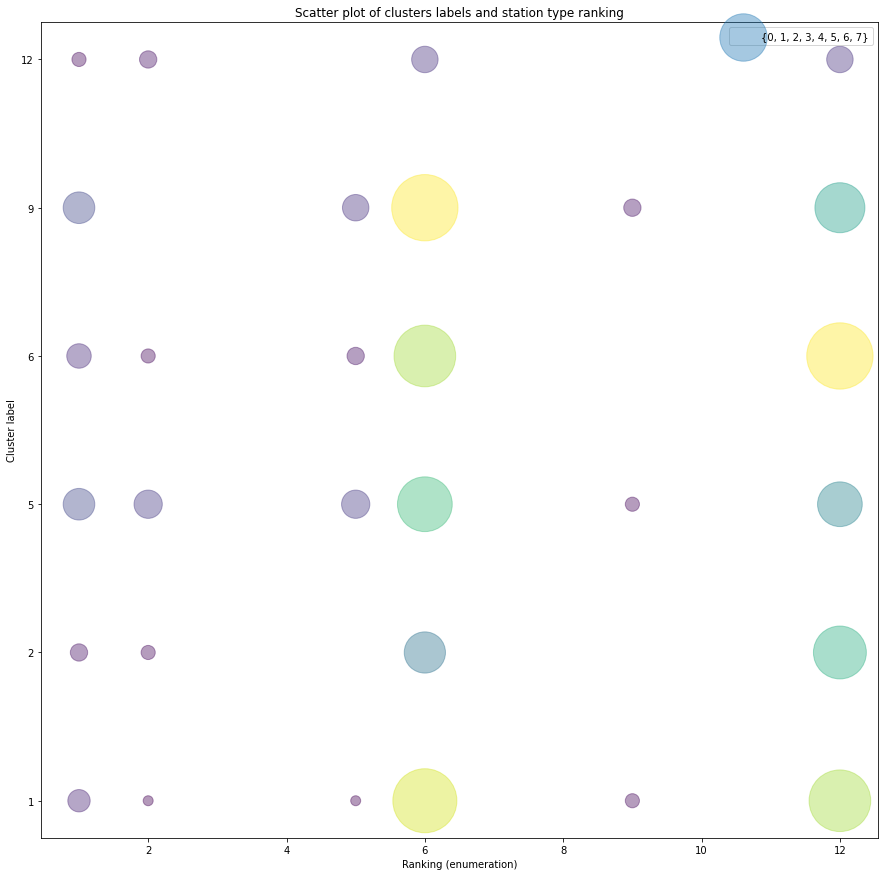

In [12]:
'''
    SCATTER PLOT of the clusters and cluster centers
    TODO colour code the clusters
'''
#import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
coords = np.array([[row[6],row[7]] for row in l_st_flt_clust])
#plt.scatter(scaled_features[:,0], scaled_features[:,1])

'''
    Calcuate the size of each cluster and station type combination in the list: [6] station rank [7] cluster label
'''
unique_labels = set(row[6] for row in l_st_flt_clust)
unique_st_ranks = set(row[7] for row in l_st_flt_clust)

l_clust_size = []
for cl_label in range(len(unique_labels)):
    l_st_ranks =[row[6] for row in l_st_flt_clust if row[7] == cl_label]
    for st_rank in range(len(l_st_ranks)):
        size = 100*len([row for row in l_st_ranks if row == st_rank])
        if size > 0:
            l_clust_size.append([st_rank,cl_label,size])
arr_plot = np.array(l_clust_size)

'''
    Scatter plot axis and labeling
    TODO fix the colours and axis labels
'''
plt.scatter(arr_plot[:,0], arr_plot[:,1], alpha=0.4, c=arr_plot[:,2], s=arr_plot[:,2], label=set(y_kmeans))
#plt.scatter(coords[:,0], coords[:,1], alpha=0.4, c=y_kmeans, s=300, label=set(y_kmeans))
plt.title('Scatter plot of clusters labels and station type ranking')
plt.xlabel('Ranking (enumeration)')
plt.yticks(range(0,len(unique_labels)),unique_labels)
#plt.xticks(range(0,len(unique_st_ranks)),unique_st_ranks)
plt.ylabel('Cluster label')
plt.legend()
plt.show()

#### Proximity Map
We use [LineCollection in Matplotlib](https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors) to construct the station to fault distance line segments. The colour coding represents the cluster.

No handles with labels found to put in legend.


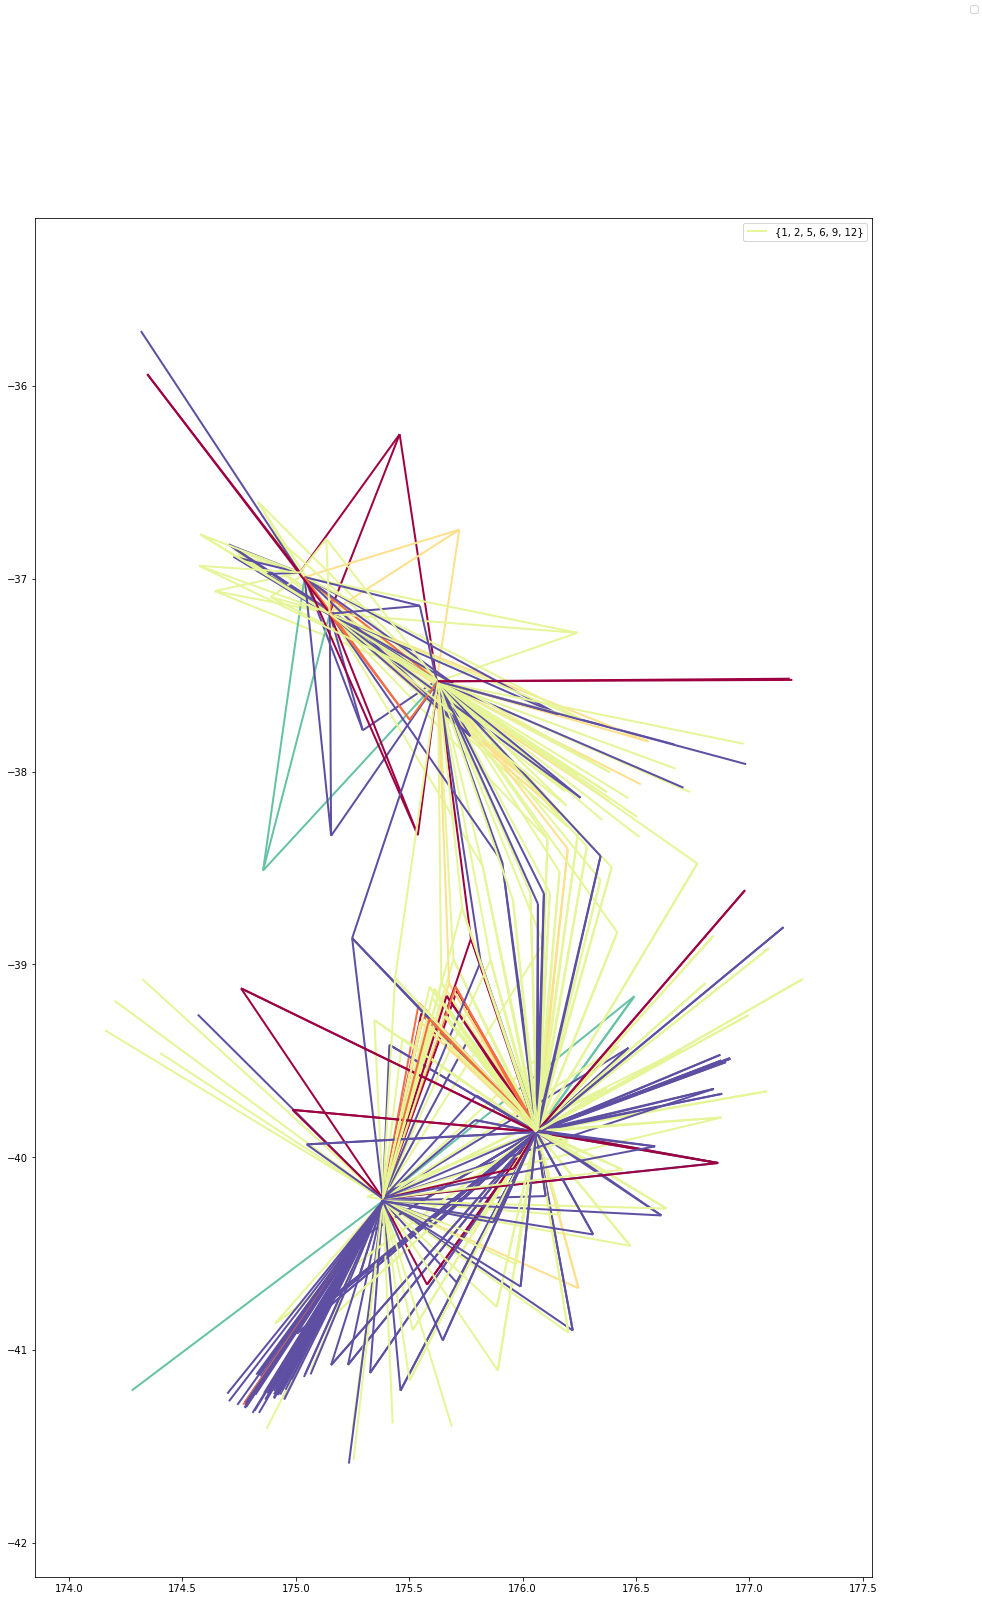

In [13]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

'''
    Create a list of station and fault coordinate tuples
'''
l_st = list(tuple(row[2]) for row in l_st_flt_clust)
l_flt = list(tuple(row[4]) for row in l_st_flt_clust)
l_coords = [[tuple(row[0]),tuple(row[1])] for row in list(zip(l_st, l_flt))]

'''
    Build the colour scheme corresponding with the cluster labels
'''
unique_labels = set([row[6] for row in l_st_flt_clust])
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

l_colours = list(row[6] for row in l_st_flt_clust)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    for col_indx, col_label in enumerate(l_colours):
        if l_colours[col_indx] == k:
            l_colours[col_indx] = col

'''
    Plot the line collection
'''
lc = mc.LineCollection(l_coords, colors=l_colours, linewidths=2)
fig, ax = pl.subplots()
fig.set_size_inches(15, 25)
fig.legend()
ax.add_collection(lc)
ax.margins(0.1)
ax.legend([lc],[unique_labels])

#### Voroni diagram
Plot clusters as [Voroni Cells](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html) with varied colors unique to each cluster and also displaying the centroid. Voronoi diagrams are many and often include [determining which feature is closest to any given point](https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134) --  determine which station is nearest at a given fault path in a neighbourhood.

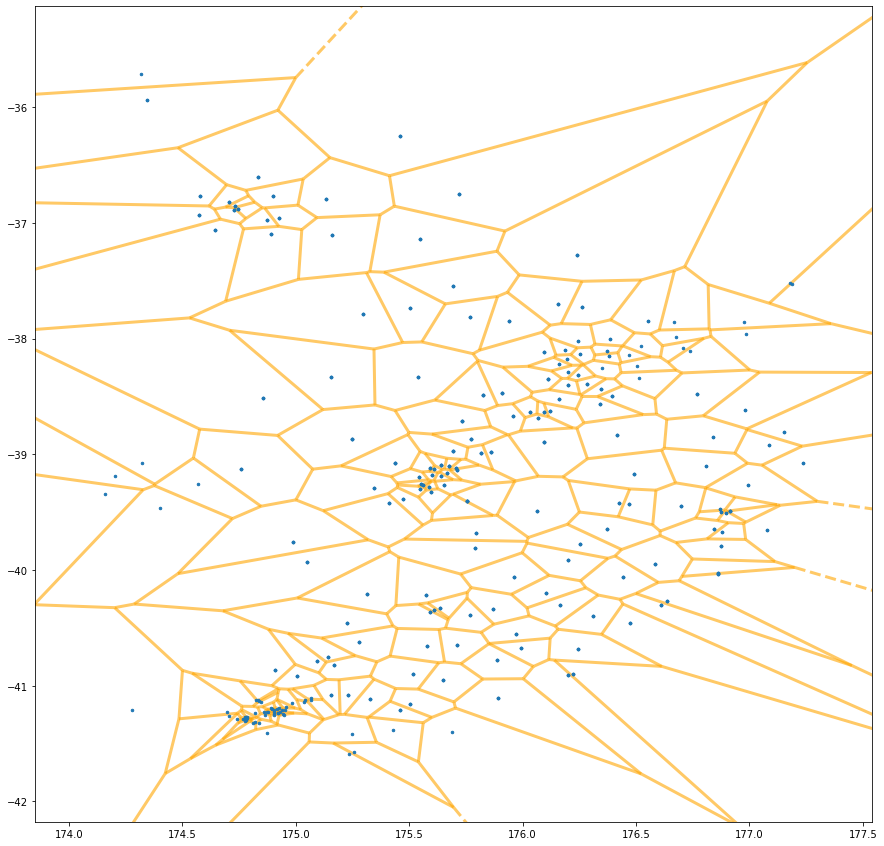

In [14]:
'''
    PLOT Voroni diagram of the stations
    TODO put inside geographic boundary
'''
from scipy.spatial import Voronoi, voronoi_plot_2d
#arr_clust_coords = np.array([[row[0],row[6]] for row in l_st_flt_clust])
#print([labels[:],scaled_features[:, 0], scaled_features[:, 1]])
arr_coord = np.array(list([row[2][0],row[2][1]] for row in l_st_flt_clust))
vor = Voronoi(arr_coord)
#fig = voronoi_plot_2d(vor)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', 
                      line_width=3, line_alpha=0.6, point_size=5)
fig.set_size_inches(15,15)
#plt.axis("equal")
#plt.xlim

In [15]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(30, 40))
#nz_map = Basemap(width=15000,height=15000,projection='merc',
#            resolution='l',lat_0=-40,lon_0=176.)
#nz_map.drawcoastlines()

l_coords = [row[2] for row in l_st_flt_clust]
print(coords)

# Black removed and is used for noise instead.
unique_labels = set(l_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (l_labels == k)

    xy = station_coordinates[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # uncomment to plot the noise
    #xy = station_coordinates[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

[[ 6  7]
 [ 6  1]
 [ 6  0]
 ..., 
 [ 6  6]
 [ 6  6]
 [12  0]]


NameError: name 'station_coordinates' is not defined

<Figure size 2160x2880 with 0 Axes>

# DISCUSSION

## Data preperation

## Clustering

### DBSCAN results
It is evident from the cluster with large volume of data points are spread across the geography. Therefore, DBSCAN is shown to be innopriate for clustering stations to estimate whether they hold the property of being 30Km within each other.


## RESOURCES
1. [Global data services and standards](http://www.fdsn.org/services/) offered by the International Federation Data of Seismic Networks (FDSN). 
1. GEONET resources:
   1. [Stream Naming Conventions](https://www.geonet.org.nz/data/supplementary/channels) are based on historical usage together with recommendations from the [SEED manual](https://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf)
   1. [Python tutorials](https://www.geonet.org.nz/data/tools/Tutorials) for using GeoNet resources
1. [Seismo-Live](https://krischer.github.io/seismo_live_build/html/Workshops/2017_Baku_STCU_IRIS_ObsPy_course/07_Basic_Processing_Exercise_solution_wrapper.html) examples of get station waveform, inventory, event, arrival time, response, and plotting using obspy
1. Choosing [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) over KMeans: 
   1. Discussion of the [three clustering methods](https://realpython.com/k-means-clustering-python/): K means, hierachical, and density-based clustering
   1. Fundermentally KMeans requires us to first select the number of clusters we wish to find and DBSCAN doesn't.
   1. [clustering to reduce spatial data sizes](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) KMeans is not an ideal algorithm for latitude-longitude spatial data because it minimizes variance, not geodetic distance. 
   1. [Explanation of DBSCAN clustering](https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31) also identifies a drawback of KMeans clustering as it is vulnerable to outliers and outliers have a significant impact on the way the centroids moves.
1. [Example of scikit-learn DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
1. [obspy.geodetics](https://docs.obspy.org/packages/obspy.geodetics.html) - various geodetic utilities for ObsPy - try an alternative clustering method with obspy geodetics
1. Mapping tutorials
   1. Visualization: [Mapping Global Earthquake Activity](http://introtopython.org/visualization_earthquakes.html)
   1. Plotting data on a map [(Example Gallery)](https://matplotlib.org/basemap/users/examples.html)
1. Calculating a [perpendicular distance to a line](https://math.stackexchange.com/questions/993236/calculating-a-perpendicular-distance-to-a-line-when-using-coordinates-latitude), when using coordinates (latitude & longitude)
1. Apply the [moment tensor](https://earthquake.usgs.gov/learn/glossary/?term=moment%20tensor); especially, the Seismic Moment Tensor Inversion (SMTI) analysis when computing fault line movement and picking the stations that might be first triggered because the [moment tensor would determine the intensity and wave propogation characteristics](https://www.esgsolutions.com/technical-resources/microseismic-knowledgebase/what-is-a-moment-tensor). 